In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
# sys.path.append('/mloscratch/homes/yixuan/PDM')
sys.path.append('/capstor/users/cscs/xyixuan/PDM/')

In [3]:
import numpy as np
from datasets import load_dataset, Features, Value
from tqdm import tqdm
from src.verbatim_eval.edit_distance import compute_ngram_distance_damerau_levenshtein
from src.verbatim_eval.LCS import find_longest_common_substrings
from src.verbatim_eval.exact_match import CommonSubstringMatcher
from src.verbatim_eval.utils import load_inference_data
from src.gutenberg.config import DataConfig
from typing import Union, List, Dict
import matplotlib.pyplot as plt
import logging

/users/xyixuan/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
logging.getLogger().setLevel(logging.WARNING)
logging.getLogger('src.verbatim_eval.LCS').setLevel(logging.WARNING) # or logging.DEBUG to show

### Longest Verbatim Memorisation

In [5]:
def calc_lcs_lengths(base_dir: str, experiment: Union[str, List[str]], reptitions: np.ndarray) -> dict[str, float]:
    """
    Calculate longest common substring lengths between true and generated suffixes.
    """
    results = {}

    if isinstance(experiment, str):
        experiment = [experiment]

    for expr in tqdm(experiment, desc="Processing experiments", position=0):
        results[expr] = {}

        for rep in tqdm(reptitions, desc=f"Computing LCS for {expr}", leave=False, position=1):
            data = load_inference_data(f"{base_dir}/{expr}/inference", rep=rep)
            lcs_res = find_longest_common_substrings(
                data['true_suffix'], 
                data['generated_suffix']
            )

            # Store lengths for this repetition
            results[expr][f"rep_{rep}"] = lcs_res.max_length.tolist()
        
    return results

def calculate_stats(lcs_results: Dict[str, Dict[str, List[float]]], mode: str, stat_functions: Dict[str, callable]) -> Dict[str, Dict[str, float]]:
    """Calculate statistics for each experiment and repetition."""
    stats = {}
    stat_func = stat_functions[mode]
    
    for expr, rep_results in lcs_results.items():
        stats[expr] = {}
        for rep, lengths in rep_results.items():
            stats[expr][rep] = stat_func(lengths)
    
    return stats

def plot_single_stat(ax, stats: Dict[str, Dict[str, float]], repetitions: np.ndarray, mode: str):
    """Plot a single statistic on the given axes."""
    for experiment, rep_stats in stats.items():
        x = list(repetitions)
        y = [rep_stats[f"rep_{rep}"] for rep in repetitions]
        ax.plot(x, y, marker='o', label=experiment)
    
    # Customize plot
    ax.set_xscale('log', base=2)
    ax.grid(True, which="both", ls="-", alpha=0.2)
    ax.grid(True, which='minor', linestyle=':', alpha=0.2)
    ax.set_xlabel('Number of Repetitions')
    ax.set_ylabel(f'{mode.capitalize()} LCS Length')
    ax.set_title(f'{mode.capitalize()} LCS Lengths')
    ax.legend()

def plot_lcs_stats(lcs_results: Dict[str, Dict[str, List[float]]], 
                   repetitions: np.ndarray, 
                   mode: str = 'mean') -> Dict[str, Dict[str, float]]:
    """
    Calculate and plot statistics from LCS results.
    
    Args:
        lcs_results: Nested dictionary of LCS results
            {experiment: {rep_x: [lengths], ...}, ...}
        repetitions: Array of repetition numbers
        mode: Statistical operation ('mean', 'std', 'max', 'all')
            
    Returns:
        Dictionary of calculated statistics
        {experiment: {rep_x: stat_value, ...}, ...}
    """
    stat_functions = {
        'mean': np.mean,
        'std': np.std,
        'max': np.max,
    }

    if mode == 'all':
        # Create subplots for all stats
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        stats_list = list(stat_functions.keys())
        
        # Plot each statistic
        for stat, ax in zip(stats_list, axes):
            stats = calculate_stats(lcs_results, stat, stat_functions)
            plot_single_stat(ax, stats, repetitions, stat)
        
        plt.tight_layout()
        plt.show()
        return None
    
    else:
        if mode not in stat_functions:
            raise ValueError(f"Mode must be one of {list(stat_functions.keys())} or 'all'")
        
        # Calculate and plot single statistic
        stats = calculate_stats(lcs_results, mode, stat_functions)
        fig, ax = plt.subplots(figsize=(10, 6))
        plot_single_stat(ax, stats, repetitions, mode)
        
        plt.tight_layout()
        plt.show()
        return stats

In [6]:
experiments=[
    'llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60',
    # 'llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_480',
    'llama_1.5B_Sparse_Gutenberg_Standard_GBS_60',
    # 'llama_1.5B_Sparse_Gutenberg_Standard_GBS_1200'
]

reptitions = np.array([1, 2, 3, 4, 8, 16, 24, 32, 48, 64, 96, 128])

In [7]:
lcs_results = calc_lcs_lengths(
    base_dir='/iopsstor/scratch/cscs/xyixuan/experiment',
    experiment=experiments,
    reptitions=reptitions
)

Processing experiments:   0%|          | 0/2 [00:00<?, ?it/s]

Processing experiments: 100%|██████████| 2/2 [00:10<00:00,  5.04s/it]


In [11]:
lcs_results.keys()

for expr in lcs_results:
    print(expr)
    for rep in lcs_results[expr]:
        print(f"  {rep}: {np.mean(lcs_results[expr][rep])}")

llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60
  rep_1: 3.806
  rep_2: 3.77
  rep_3: 3.606
  rep_4: 3.696
  rep_8: 3.954
  rep_16: 3.914
  rep_24: 4.322
  rep_32: 5.094
  rep_48: 5.888
  rep_64: 6.372
  rep_96: 7.814
  rep_128: 9.52
llama_1.5B_Sparse_Gutenberg_Standard_GBS_60
  rep_1: 3.65
  rep_2: 3.918
  rep_3: 3.788
  rep_4: 3.902
  rep_8: 3.948
  rep_16: 4.028
  rep_24: 3.972
  rep_32: 4.25
  rep_48: 4.298
  rep_64: 4.4
  rep_96: 4.31
  rep_128: 4.546


In [12]:
def plot_rep_exact_match_dist(expr: str, rep: int, lcs_results: dict[str, dict[str, list[float]]]):
    """Plot the distribution of exact match LCS lengths for a single repetition."""
    lengths = lcs_results[expr][f"rep_{rep}"]
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(lengths, bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
    ax.set_xlabel('LCS Length')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Exact Match LCS Lengths for {expr} Rep {rep}')
    plt.show()

In [61]:
def plot_rep_exact_match_dists(expr: str, reptitions: list[int], lcs_results: dict[str, dict[str, list[float]]]):
    """Plot the distribution of exact match LCS lengths for all repetitions."""
    # Find all repetitions for this expression
    n_reps = len(reptitions)
    
    # Calculate subplot layout dimensions
    n_rows = (n_reps + 3) // 4  # 3 plots per row, rounded up
    n_cols = min(4, n_reps)     # At most 3 columns
    
    # Create figure and subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    fig.suptitle(f'Exact Match LCS Lengths for {expr}')
    
    # Flatten axes array if we have multiple rows
    if n_rows > 1:
        axes = axes.flatten()
    
    # Plot each repetition
    for idx, rep in enumerate(reptitions):
        rep_key = f"rep_{rep}"
        lengths = lcs_results[expr][rep_key]
        ax = axes[idx] if n_reps > 1 else axes
        
        ax.hist(lengths, bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
        ax.set_xlabel('LCS Length')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Rep {rep_key.split("_")[1]}')
        # ax.set_ylim(0, 500)  # Set y-axis limit to 500
        ax.set_xlim(0, 500)  # Set y-axis limit to 500
        ax.set_yscale('log')  # Set logarithmic scale for y-axis
        # ax.set_xscale('log')

    
    # Remove empty subplots if any
    if n_reps > 1:
        for idx in range(n_reps, len(axes)):
            fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()

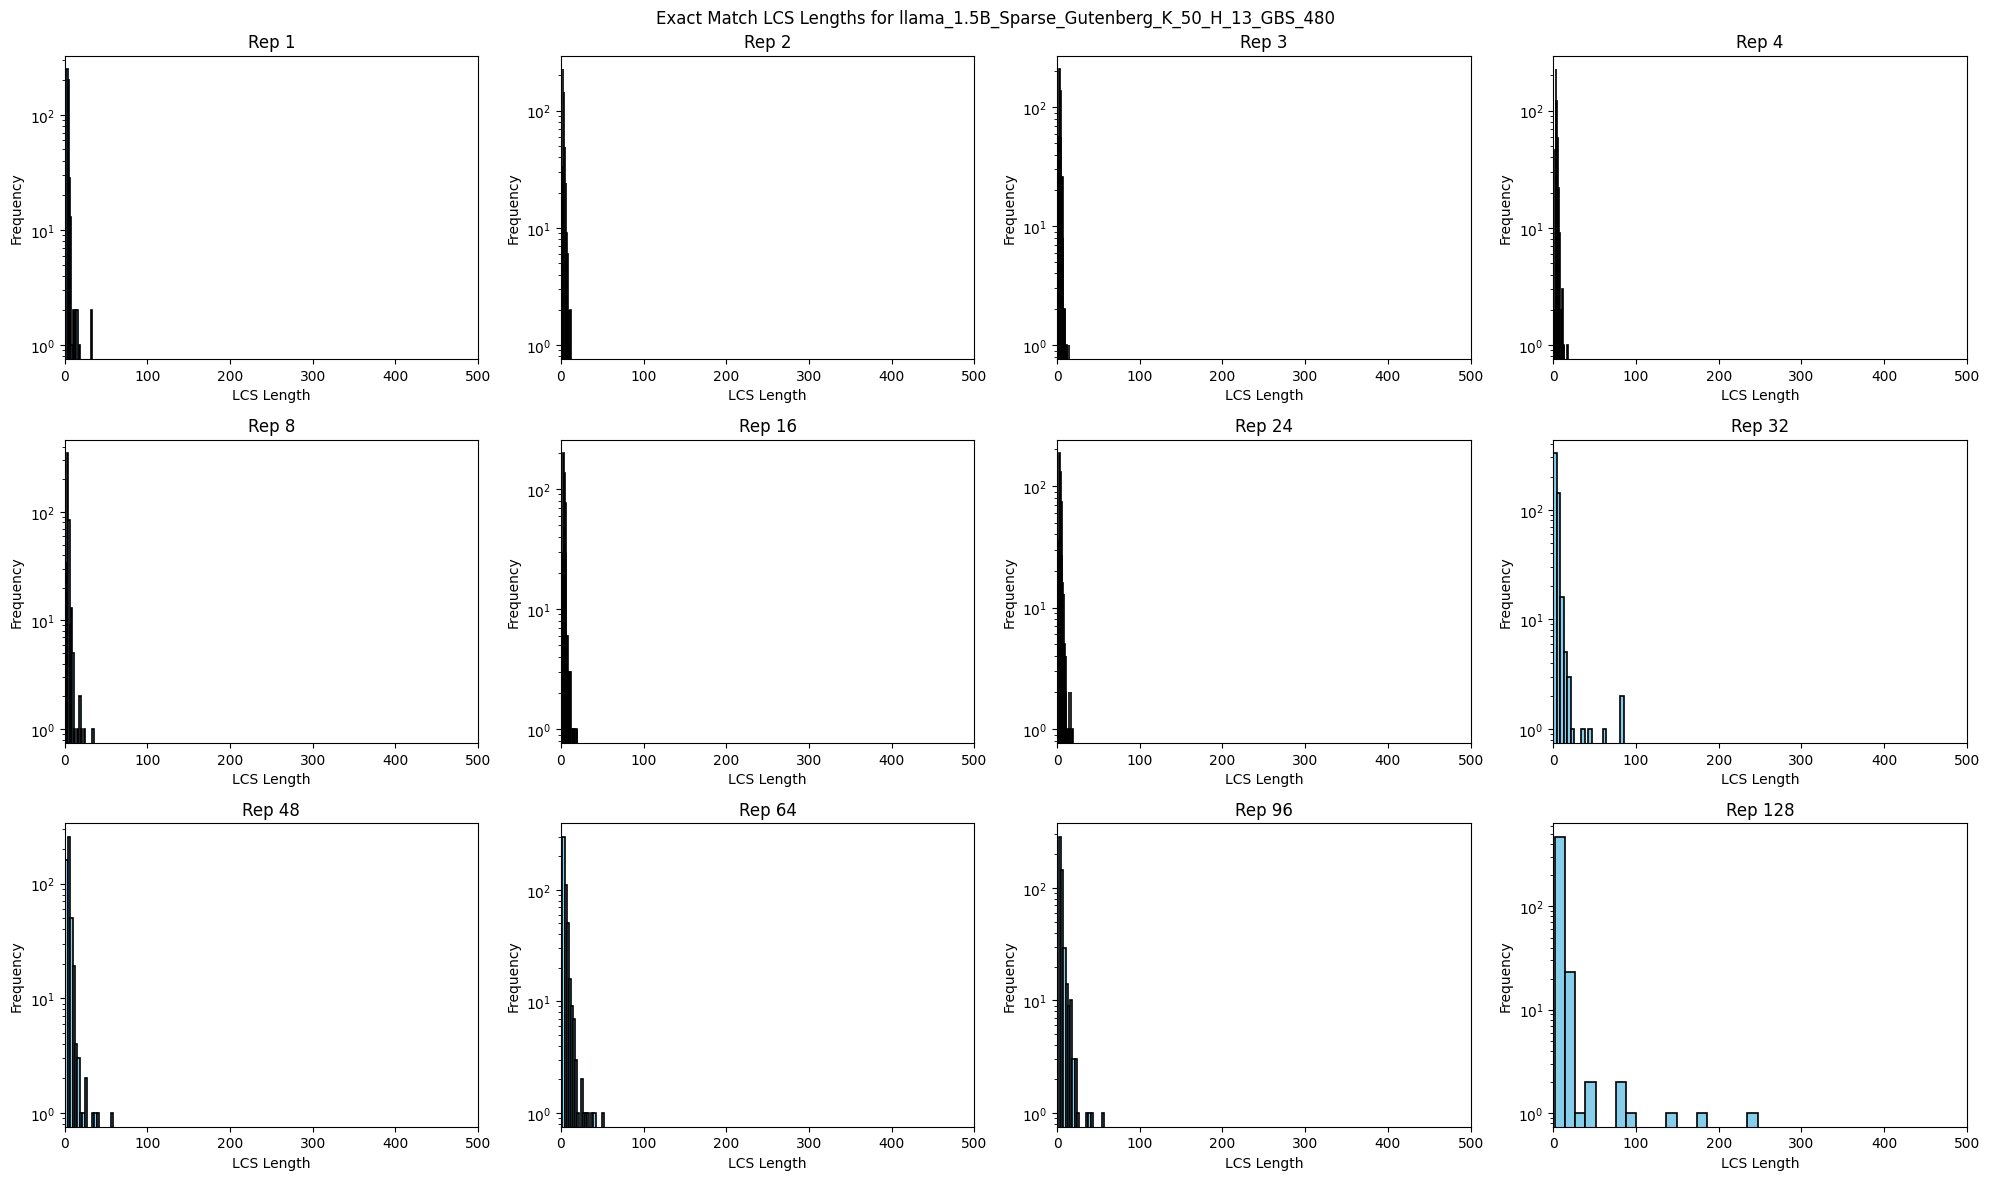

In [69]:
plot_rep_exact_match_dists(
    expr=experiments[1],
    reptitions=reptitions,
    lcs_results=lcs_results
)

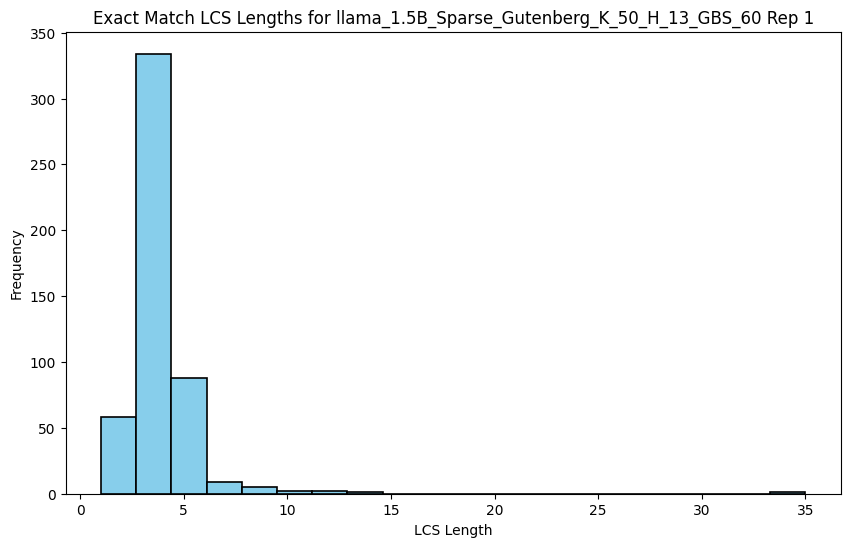

In [15]:
plot_rep_exact_match_dist(
    expr=experiments[0],
    rep=1,
    lcs_results=lcs_results
)

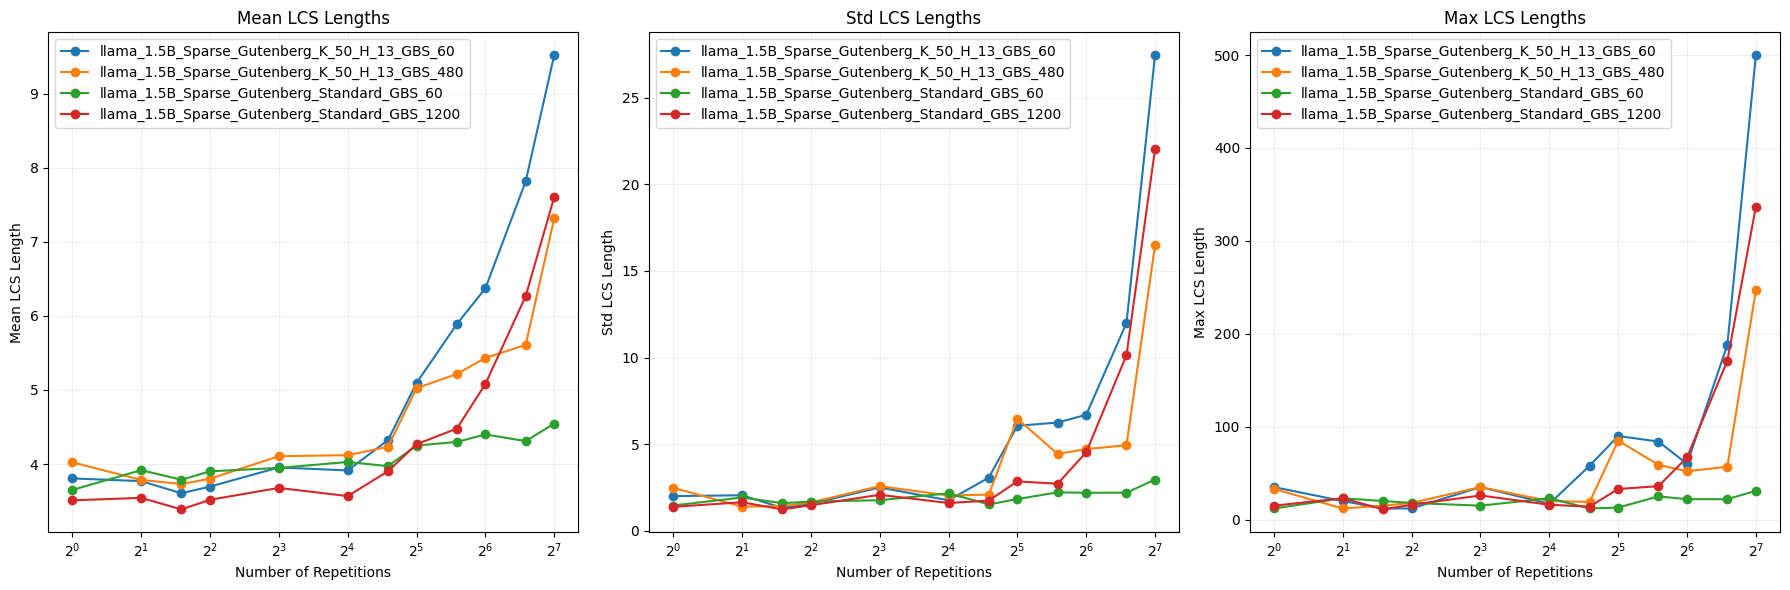

In [10]:
plot_lcs_stats(
    lcs_results, 
    repetitions=np.array([1, 2, 3, 4, 8, 16, 24, 32, 48, 64, 96, 128]),
    mode='all'
)

### All Verbatim memorisations

In [93]:
def calc_avg_cs_lengths(base_dir: str, experiments: Union[str, List[str]], reptitions: np.ndarray):
    """
    Calculate average common substring lengths between true and generated suffixes for each sequence.
    """
    results = {}

    if isinstance(experiments, str):
        experiments = [experiments]

    for expr in experiments:
        results[expr] = {}

        for rep in tqdm(reptitions, desc=f"Computing CS for {expr}"):
            data = load_inference_data(f"{base_dir}/{expr}/inference", rep=rep)
            
            cs_master = CommonSubstringMatcher(
                data['true_suffix'], 
                data['generated_suffix']
            )

            matches = cs_master.get_all_matches()
            
            results[expr][f"rep_{rep}"] = np.nanmean([
                np.mean([match.length if match is not None else 0 for match in sample])
                for sample in matches
            ])
            
    return results

In [98]:
cs_results = calc_avg_cs_lengths(
    base_dir='/iopsstor/scratch/cscs/xyixuan/experiment', 
    experiments=experiments, 
    reptitions=DataConfig.repetitions()
)

Computing CS for llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60:   0%|          | 0/12 [00:00<?, ?it/s]

Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1097.50sequence/s]
/users/xyixuan/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/users/xyixuan/miniconda3/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1173.16sequence/s]███▏| 11/12 [00:12<00:01,  1.02s/it]
Computing CS for llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60: 100%|██████████| 12/12 [00:13<00:00,  1.10s/it]
Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1164.50sequence/s]████▏| 11/12 [00:11<00:01,  1.05s/it]
Computing CS for llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_480: 100%|██████████| 12/12 [00:12<00:00,  1.06s/it]
Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1189.22sequence/s]██▏| 11/12 [00:11<00:01,  1.02s/it]
Computing CS 

In [99]:
cs_results

{'llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60': {'rep_1': np.float64(2.1266267097206955),
  'rep_2': np.float64(2.113152474173603),
  'rep_3': np.float64(2.1131210996584415),
  'rep_4': np.float64(2.107830677063837),
  'rep_8': np.float64(2.132047859345271),
  'rep_16': np.float64(2.1254246462809347),
  'rep_24': np.float64(2.1283995736124313),
  'rep_32': np.float64(2.1635313292657603),
  'rep_48': np.float64(2.167743333523887),
  'rep_64': np.float64(2.1850352801647066),
  'rep_96': np.float64(2.1609703520875363),
  'rep_128': np.float64(3.1854290397168006)},
 'llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_480': {'rep_1': np.float64(2.1312787084071143),
  'rep_2': np.float64(2.1229258569638327),
  'rep_3': np.float64(2.11709045277077),
  'rep_4': np.float64(2.1221649367386344),
  'rep_8': np.float64(2.1317234236297624),
  'rep_16': np.float64(2.1452957088247944),
  'rep_24': np.float64(2.129072930964862),
  'rep_32': np.float64(2.162828417604372),
  'rep_48': np.float64(2.14511720577118